In [1]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import itertools
import time
import sys

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import nltk
nltk.download('rslp')

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator
from itertools import combinations
import cloudpickle as cp
import scikitplot as skplt

import warnings
warnings.simplefilter("ignore")

[nltk_data] Downloading package rslp to /home/jovyan/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.


# Index:
* [Data Extraction](#data-extraction)
* [Data Formatting](#data-formatting)
    * [NLP](#nlp)
    * [Pre-Processor](#pre-processor)
    * [Data Split](#data-split)
* [Modeling](#modeling)
* [Model Validation](#model-validation)
    * [Random Search](#random-search)
        * [Text Hyperparameters](#text-hyperparameters)
        * [Validation Metrics](#validation-metrics)
    * [Test Metrics](#test-metrics)
* [Model Exportation](#model-exportation)

In [2]:
seed_value = 42
os.environ['PYTHONHASHSEED'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

## Data Extraction <a class="anchor" id="data-extraction"></a>

In [3]:
DATASET_PATH = os.getenv("DATASET_PATH")

sample = pd.read_csv(DATASET_PATH)
sample.shape

(38000, 15)

In [4]:
sample.head()

,product_id,seller_id,query,search_page,position,title,concatenated_tags,creation_date,price,weight,express_delivery,minimum_quantity,view_counts,order_counts,category
0,11394449,8324141,espirito santo,2,6,Mandala Espírito Santo,mandala mdf,2015-11-14 19:42:12,171.890000,1200.0,1,4,244,NaN,Decoração
1,15534262,6939286,cartao de visita,2,0,Cartão de Visita,cartao visita panfletos tag adesivos copos lon...,2018-04-04 20:55:07,77.670000,8.0,1,5,124,NaN,Papel e Cia
2,16153119,9835835,expositor de esmaltes,1,38,Organizador expositor p/ 70 esmaltes,expositor,2018-10-13 20:57:07,73.920006,2709.0,1,1,59,NaN,Outros
3,15877252,8071206,medidas lencol para berco americano,1,6,Jogo de Lençol Berço Estampado,t jogo lencol menino lencol berco,2017-02-27 13:26:03,118.770004,0.0,1,1,180,1.0,Bebê
4,15917108,7200773,adesivo box banheiro,3,38,ADESIVO BOX DE BANHEIRO,adesivo box banheiro,2017-05-09 13:18:38,191.810000,507.0,1,6,34,NaN,Decoração


In [5]:
sample.isna().sum(axis=0)

product_id               0
seller_id                0
query                    0
search_page              0
position                 0
title                    0
concatenated_tags        2
creation_date            0
price                    0
weight                  58
express_delivery         0
minimum_quantity         0
view_counts              0
order_counts         20105
category                 0
dtype: int64

In [6]:
sample['category'].value_counts()

Lembrancinhas         17524
Decoração              8723
Bebê                   6930
Papel e Cia            2750
Outros                 1133
Bijuterias e Jóias      940
Name: category, dtype: int64

## Data Formatting <a class="anchor" id="data-formatting"></a>

We selected all columns from the CSV file, with the exception of the product_id and seller_id columns, as they don't contain meaningful information about the categories we want to predict. 

In [7]:
numerical_columns = sample.select_dtypes("number").columns.tolist()[2:]
text_columns = ['title', 'query', 'concatenated_tags']

In [8]:
X = sample[numerical_columns + text_columns]
y = sample["category"]

X.loc[:, 'title'] = X['title'].str.lower()
X.loc[:, text_columns] = X.loc[:, text_columns].fillna("")

### NLP <a class="anchor" id="nlp"></a>

We used Bag of Words in our pipeline, because it is a simple way to extract information from the text. We also experimented with Tf-idf, which improved our results.

In [9]:
class TextColumnConcatenation(BaseEstimator):

    def __init__(self, columns = ['title']):
        self.columns = columns
        
    def transform(self, X):
        if len(self.columns) > 1:
            return X[self.columns].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
        else:
            return X[self.columns[0]]

    def fit(self, X, y=None):
        return self

In [10]:
def get_regex_word(min_word_length, max_word_length):
    return rf'(?u)\b[^\d\W]{{{min_word_length},{max_word_length}}}\b'

class CountVectorizerWithStemming(CountVectorizer):
    
    def __init__(self, stemming=False, min_word_length=1, max_word_length=20, stop_words=None):
        
        self.stemming = stemming
        self.min_word_length = min_word_length
        self.max_word_length = max_word_length
        self.stop_words = stop_words
    
        token_pattern = get_regex_word(min_word_length, max_word_length)
        
        parameters = {"token_pattern": token_pattern,
                      "stop_words": stop_words}
        if stemming:
            
            analyzer = CountVectorizer(**parameters).build_analyzer()
            stemmer = nltk.stem.RSLPStemmer()
            
            def apply_stem(sentence):
                return (stemmer.stem(w) for w in analyzer(sentence))
        
            parameters['analyzer'] = apply_stem
        
        super().__init__(**parameters)

### Pre-processor <a class="anchor" id="pre-processor"></a>

In [11]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ("scaler", StandardScaler())
])

text_transformer = Pipeline(steps=[
    ("text_column_concatenation", TextColumnConcatenation()),
    ("count_vectorizer", CountVectorizerWithStemming()),
    ("tf_idf", "passthrough"),
    ("scaler", StandardScaler(with_mean=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('numerical', numerical_transformer, numerical_columns),
    ('categorical', text_transformer, text_columns)
])

### Data Split <a class="anchor" id="data-split"></a>

We divided the data into training and test subsets, using stratification so that the proportion of classes is maintained in both subsets of the data.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed_value, test_size=.2, stratify=y)

## Modeling <a class="anchor" id="modeling"></a>

We used a combination of simple classifiers (Logistic Regression, Decision Tree) and more complex ones (Random Forest, Multi-Layer Perceptron). And we chose the best one based on the validation metrics.

In [13]:
pipe_log = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("classifier", LogisticRegression(random_state=seed_value))
    ]
)

pipe_tree = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("classifier", DecisionTreeClassifier(random_state=seed_value))
    ]
)

pipe_rf = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("classifier", RandomForestClassifier(random_state=seed_value))
    ]
)

pipe_mlp = Pipeline(
    [
        ('preprocessor', preprocessor),
        ("classifier", MLPClassifier(max_iter=100, random_state=seed_value))
    ]
)

## Model Validation <a class="anchor" id="model-validation"></a>

For validation and hyperparameter search, we used RandomSearch and StratifiedKfold. RandomSearch is usually better than GridSearch and less computationally expensive. 

Since we have an imbalanced dataset, we shouldn't use accuracy as our only metric. Therefore, we used f1, precision, recall and the ROC AUC score. Our random search optimization uses the ROC AUC score to return the best model.

We also manually tweaked the hyperparameters for some promissing models.

### Random Search <a class="anchor" id="random-search"></a>

In [14]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed_value)

In [15]:
scoring = {'f1': 'f1_weighted', 'precision': 'precision_weighted', 'recall': 'recall_weighted', 
           'roc_auc': 'roc_auc_ovo_weighted'}

In [16]:
def save_model(model, path):
    with open(path, "wb") as file:
        cp.dump(model, file)
    print("Model saved at:", path)

    
def load_model(path):
    with open(path, "rb") as file:
        return cp.load(file)

In [17]:
def search_pipeline(pipeline, search_space, scoring, cv, random_state, X, y, load_best=False, n_iter=10,
                    model_name=None, save=False):
    """ Creates a random search for pipeline, fits the data, and returns the random search object
        
        if load_best is true, then it skips training and loads the best model instead
    """
    if model_name == None:
        model_name = f"RandomSearch{pipeline['classifier'].__class__.__name__}.pkl"
    
    best_models_path = os.getenv("BEST_MODELS_PATH")
    model_path = os.path.join(best_models_path, model_name)
    
    if load_best:
        search = load_model(model_path)
    else:
        print("Training...")
        search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=search_space,
            cv=cv,
            verbose=1,
            n_jobs=-1,
            random_state=random_state,
            scoring=scoring,
            refit="roc_auc",
            n_iter=n_iter,
            return_train_score=True,
        )
        start = time.time()
        search.fit(X_train, y_train)
        stop = time.time()
        print(f"Training time: {(stop - start) / 60} minutes")
        if save:
            save_model(search, model_path)       
    
    return search

In [18]:
def get_search_metrics(search):
    best_index = search.best_index_
    metrics = search.scorer_.keys()
    data_modes = ["train", "test"]
    statistics = ["mean", "std"]
    
    iterables = [data_modes, statistics]
    index = pd.MultiIndex.from_product(iterables, names=["data", "statistic"])
    
    df = pd.DataFrame(index=index, columns=metrics)
    
    for metric in metrics:
        for data_mode in data_modes:
            for statistic in statistics:
                df.loc[(data_mode, statistic), 
                       metric] =  search.cv_results_[f'{statistic}_{data_mode}_{metric}'][best_index]
    return df.loc[:, :].astype(float).round(3)

#### Text-Hyperparameters <a class="anchor" id="text-hyperparameters"></a>

We used hyperparameters in our data processing phase to help with generalization. These hyperparameters are 

* stemming
* minimum and maximum word length 
* stop words. 

Very small or large words don't help our classifier as they don't contain meaningful information.

In [19]:
columns_combinations = []
for r in range(1, len(text_columns) + 1):
    combination = []
    for value in combinations(text_columns, r):
        combination.append(list(value))
    columns_combinations += combination
columns_combinations

[['title'],
 ['query'],
 ['concatenated_tags'],
 ['title', 'query'],
 ['title', 'concatenated_tags'],
 ['query', 'concatenated_tags'],
 ['title', 'query', 'concatenated_tags']]

In [20]:
stopwords_url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-pt/master/stopwords-pt.txt"
stopwords = pd.read_csv(stopwords_url, header=None)[0].tolist()
stopwords[:10]

['a',
 'acerca',
 'adeus',
 'agora',
 'ainda',
 'alem',
 'algmas',
 'algo',
 'algumas',
 'alguns']

In [21]:
text_hyperparams = {
    "preprocessor__categorical__text_column_concatenation__columns": columns_combinations,
    "preprocessor__categorical__count_vectorizer__stop_words": [None, stopwords],
    "preprocessor__categorical__count_vectorizer__min_word_length": [3, 4, 5, 6],
    "preprocessor__categorical__count_vectorizer__max_word_length": [15, 15, 16],
    "preprocessor__categorical__count_vectorizer__stemming": [False, True],
    "preprocessor__categorical__tf_idf": ["passthrough", TfidfTransformer()],
}

#### Validation Metrics <a class="anchor" id="validation-metrics"></a>

In [22]:
load_best = True # set this flag to False if you want to run the random search
n_iter = 10

In [23]:
search_space_tree = {
    "classifier__criterion": ['gini', 'entropy'],
    "classifier__max_depth": [2, 4, 6, 8, 10, 12]
}

search_space_tree.update(text_hyperparams)

best_pipe_tree = search_pipeline(pipe_tree, search_space_tree, scoring, cv, seed_value, 
                                 X_train, y_train, load_best=load_best, n_iter=n_iter, save=True)
get_search_metrics(best_pipe_tree)

f1  precision  recall  roc_auc
data  statistic                                   
train mean       0.699      0.789   0.724    0.897
      std        0.003      0.018   0.002    0.002
test  mean       0.665      0.736   0.695    0.862
      std        0.005      0.012   0.004    0.002

In [24]:
search_space_log = {
    "classifier__penalty": ['l2', 'l1'],
    "classifier__C": np.logspace(0, 4, 10),
    "classifier__solver":['newton-cg', 'saga', 'liblinear']
}

search_space_log.update(text_hyperparams)

best_pipe_log = search_pipeline(pipe_log, search_space_log, scoring,  cv, seed_value,
                                X_train, y_train, load_best=load_best, n_iter=n_iter, save=True);
get_search_metrics(best_pipe_log)

f1  precision  recall  roc_auc
data  statistic                                   
train mean       0.908      0.909   0.909    0.987
      std        0.001      0.001   0.001    0.000
test  mean       0.857      0.857   0.860    0.963
      std        0.003      0.003   0.004    0.002

In [25]:
search_space_rf = {
    "classifier__n_estimators": [10, 100, 1000],
    "classifier__max_depth":[5, 8, 15, 25, 30, None],
    "classifier__min_samples_leaf":[1, 2, 5, 10, 15, 100],
    "classifier__max_leaf_nodes": [2, 5, 10]
}

best_pipe_rf = search_pipeline(pipe_rf, search_space_rf, scoring, cv, seed_value, 
                               X_train, y_train, load_best=load_best, n_iter=n_iter, save=True)
get_search_metrics(best_pipe_rf)

f1  precision  recall  roc_auc
data  statistic                                   
train mean       0.442      0.651   0.544    0.917
      std        0.006      0.010   0.004    0.000
test  mean       0.441      0.645   0.543    0.915
      std        0.002      0.013   0.002    0.002

In [26]:
pipe_rf_text = Pipeline(
    [
        ('preprocessor', text_transformer),
        ("classifier", RandomForestClassifier(random_state=seed_value, n_jobs=-1))
    ]
)

params_rf_text = {
    "classifier__n_estimators": [100],
    "preprocessor__text_column_concatenation__columns": [['title', 'concatenated_tags']],
    "preprocessor__count_vectorizer__stop_words": [stopwords],
    "preprocessor__count_vectorizer__max_word_length": [15],
    "preprocessor__count_vectorizer__min_word_length": [3],
    "preprocessor__count_vectorizer__stemming": [False],
    "preprocessor__tf_idf": [TfidfTransformer()],
}

manual_pipe_rf = search_pipeline(pipe_rf_text, params_rf_text, scoring, cv, seed_value, 
                                 X_train, y_train, load_best=False, n_iter=1, 
                                 model_name="ManualRandomForest.pkl")

get_search_metrics(manual_pipe_rf)

Training...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Training time: 2.4952540000279746 minutes


f1  precision  recall  roc_auc
data  statistic                                   
train mean       0.998      0.998   0.998     1.00
      std        0.000      0.000   0.000     0.00
test  mean       0.902      0.905   0.904     0.98
      std        0.002      0.002   0.002     0.00

In [27]:
search_space_mlp = {
    'classifier__hidden_layer_sizes': [(10, 30, 10),(20,)],
    'classifier__activation': ['tanh', 'relu'],
    'classifier__solver': ['sgd', 'adam'],
    'classifier__alpha': [0.0001, 0.05],
    'classifier__learning_rate': ['constant', 'adaptive']
}

search_space_mlp.update(text_hyperparams)

best_pipe_mlp = search_pipeline(pipe_mlp, search_space_mlp, scoring, cv, seed_value, 
                                X_train, y_train, load_best=load_best, n_iter=n_iter, save=True)

get_search_metrics(best_pipe_mlp)

f1  precision  recall  roc_auc
data  statistic                                   
train mean       0.990      0.990   0.990    1.000
      std        0.001      0.001   0.001    0.000
test  mean       0.862      0.862   0.863    0.949
      std        0.003      0.003   0.003    0.001

In [28]:
search_list = [best_pipe_tree, best_pipe_log, best_pipe_rf, best_pipe_mlp, manual_pipe_rf]

best_search_index = max(range(len(search_list)), key=lambda i: search_list[i].best_score_)
best_search = search_list[best_search_index]

best_score = best_search.best_score_
best_model = best_search.best_estimator_

print(f"Best Model: {best_model['classifier'].__class__.__name__} | Best ROC-AUC: {best_score}")

Best Model: RandomForestClassifier | Best ROC-AUC: 0.9799241589399881


In [29]:
validation_metrics_df = get_search_metrics(best_search)
with open(os.getenv("METRICS_PATH"), 'w') as f:
    f.write(f"Validation Metrics: \n{validation_metrics_df.to_string()}")

### Test Metrics  <a class="anchor" id="test-metrics"></a>

In [30]:
best_model.fit(X_train, y_train);

In [31]:
y_train_pred = best_model.predict(X_train)
y_train_proba = best_model.predict_proba(X_train)
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)

In [32]:
def roc_auc_score_multiclass(y_true, y_proba, labels):

    result = []
    for label_index, current_label in enumerate(labels):

        y_true_binary = (y_true == current_label).astype(float)
        y_proba_correct = y_proba[:, label_index].reshape(-1,1)
        
        result.append(roc_auc_score(y_true_binary, y_proba_correct))

    return result

In [33]:
labels = best_model.classes_

metrics = ["f1", "precision", "recall", "roc_auc"]
data_mode_list = ["train", "test"]
iterables = [metrics, data_mode_list]
index = pd.MultiIndex.from_product(iterables, names=["metric", "data"])

test_metrics_df = pd.DataFrame(index=index, columns=labels)

y_tuples = [(y_train, y_train_pred, y_train_proba), (y_test, y_test_pred, y_test_proba)]

for data_mode, y_tuple in zip(data_mode_list, y_tuples):
    y_true, y_pred, y_proba = y_tuple
    test_metrics_df.loc[("f1", data_mode), :] = f1_score(y_true, y_pred, average=None, labels=labels)
    test_metrics_df.loc[("precision", data_mode), :] = precision_score(y_true, y_pred, average=None, labels=labels)
    test_metrics_df.loc[("recall", data_mode), :] = recall_score(y_true, y_pred, average=None, labels=labels)
    test_metrics_df.loc[("roc_auc", data_mode), :] = roc_auc_score_multiclass(y_true, y_proba, labels=labels)

test_metrics_df = test_metrics_df.astype(float).round(3)
test_metrics_df

Bebê  Bijuterias e Jóias  Decoração  Lembrancinhas  Outros  \
metric    data                                                                 
f1        train  0.998               1.000      0.999          0.998   0.997   
          test   0.910               0.937      0.921          0.935   0.724   
precision train  0.999               1.000      0.999          0.998   0.999   
          test   0.937               0.961      0.918          0.904   0.931   
recall    train  0.998               1.000      0.999          0.998   0.994   
          test   0.885               0.915      0.923          0.968   0.593   
roc_auc   train  1.000               1.000      1.000          1.000   1.000   
          test   0.987               0.994      0.990          0.986   0.980   

                 Papel e Cia  
metric    data                
f1        train        0.995  
          test         0.802  
precision train        0.992  
          test         0.879  
recall    train        0.997  
          test         0.738  
roc_auc   train        1.000  
          test         0.981

In [34]:
with open(os.getenv("METRICS_PATH"), 'a') as f:
    f.write(f"\n\nTest Metrics: \n{test_metrics_df.to_string()}")

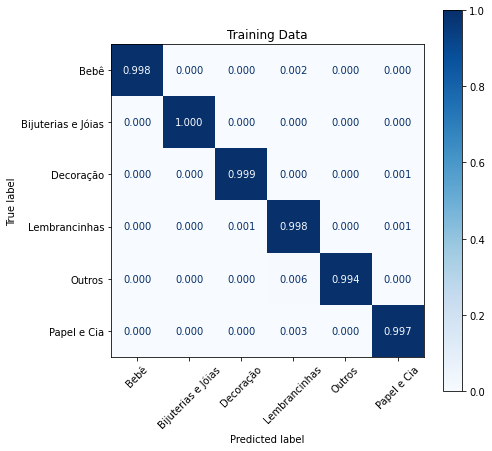

In [35]:
fig, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(best_model, X_train, y_train, normalize='true', cmap=plt.cm.Blues, ax=ax, 
                      xticks_rotation=45, values_format=".3f")
disp.ax_.set_title("Training Data")
plt.show()

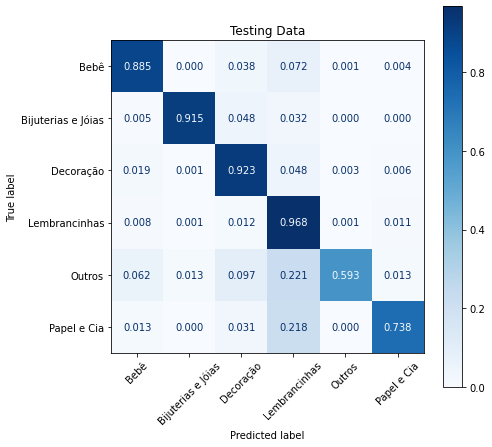

In [36]:
fig, ax = plt.subplots(figsize=(7, 7))
disp = plot_confusion_matrix(best_model, X_test, y_test, normalize='true', cmap=plt.cm.Blues, ax=ax, 
                      xticks_rotation=45, values_format=".3f")
disp.ax_.set_title("Testing Data")
plt.show()

In addition to the metrics and the confusion matrix, we think it is important to have an idea of the distribution of the categories when using the model. The table below shows the percentage of each true class in the predicted ones.

In [37]:
y_pred = best_model.predict(X_test)
df = pd.DataFrame({"True": y_test, "Predicted": y_pred})
print("Proportion of true classes in the predicted ones")
df.groupby(["Predicted"])['True'].value_counts(normalize=True).round(2)

Proportion of true classes in the predicted ones


Predicted           True              
Bebê                Bebê                  0.94
                    Decoração             0.03
                    Lembrancinhas         0.02
                    Outros                0.01
                    Papel e Cia           0.01
                    Bijuterias e Jóias    0.00
Bijuterias e Jóias  Bijuterias e Jóias    0.96
                    Outros                0.02
                    Decoração             0.01
                    Lembrancinhas         0.01
Decoração           Decoração             0.92
                    Bebê                  0.03
                    Lembrancinhas         0.02
                    Outros                0.01
                    Papel e Cia           0.01
                    Bijuterias e Jóias    0.01
Lembrancinhas       Lembrancinhas         0.90
                    Papel e Cia           0.03
                    Bebê                  0.03
                    Decoração             0.02
                    O

In [38]:
%%time
best_model.predict(X_test.head(1))

CPU times: user 44.7 ms, sys: 206 µs, total: 44.9 ms
Wall time: 62.6 ms


array(['Lembrancinhas'], dtype=object)

In [39]:
%%time
best_model.predict(X_test)

CPU times: user 1.02 s, sys: 23.8 ms, total: 1.05 s
Wall time: 665 ms


array(['Lembrancinhas', 'Papel e Cia', 'Lembrancinhas', ...,
       'Lembrancinhas', 'Lembrancinhas', 'Lembrancinhas'], dtype=object)

## Model Exportation <a class="anchor" id="model-exportation"></a>

In [40]:
best_model.fit(X, y); 

In [41]:
save_model(best_model, os.getenv("MODEL_PATH"))

Model saved at: /usr/src/data/model.pkl
